Importando todas as bibliotecas necessárias

In [1]:
import pickle
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import json
from keras.callbacks import History

Treinando os 36 modelos e salvando em disco

In [ ]:
def trainMLP(metric, epochs, hidden_layer_neuron_number, learning_rate, batch_size, test_set_percentage):
    # definindo o modelo
    mlp = tf.keras.models.Sequential()
    mlp.add(layers.Dense(784, activation='sigmoid', input_shape=(784,)))
    mlp.add(layers.Dense(hidden_layer_neuron_number, activation='sigmoid'))
    mlp.add(layers.Dense(10, activation='sigmoid'))

    # compilando o modelo
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    mlp.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[metric])

    # lendo os dados do arquivo de texto
    data = np.loadtxt('data_tp1', delimiter=',')
    X = data[:, 1:]
    y = data[:, 0]

    history = History()
    mlp.fit(X, y, validation_split=test_set_percentage, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, workers=8, callbacks=[history])
    return (mlp, history)

def saveMLP(base_folder, mlp, learning_rate, history):
    if not os.path.exists('models'):
        os.makedirs('models')

    with open(f"{base_folder}/history-lr{learning_rate}.pkl", 'wb') as file:
        pickle.dump(history.history, file)
        
    mlp.save(f"{base_folder}/mlp-lr{learning_rate}")

params = json.load(open('params.json'))

test_set_percentage = params['test_set_percentage']
metric = params['metric']
epochs = params['epochs']

# Ordenado de forma que as primeiras execuções sejam mais rápidas
batch_sizes = [round(5000 * round(1 - params['test_set_percentage'], 2))]
for batch_size in params.get('batch_sizes'):
    batch_sizes.append(batch_size)
# batch_sizes = [3750, 50, 10, 1] Originalmente

hidden_layer_neuron_numbers = params['hidden_layer_neuron_numbers']
learning_rates = params['learning_rates']

for batch_size in batch_sizes:
    batch_folder = f"models/batch-size-{batch_size}"
    if not os.path.exists(batch_folder):
        os.makedirs(batch_folder)

    for hidden_layer_neuron_number in hidden_layer_neuron_numbers:
        hidden_layer_folder = f"{batch_folder}/hidden-layer-neuron-number-{hidden_layer_neuron_number}"
        if not os.path.exists(hidden_layer_folder):
            os.makedirs(hidden_layer_folder)

        for learning_rate in learning_rates:
            mlp, history = trainMLP(metric, epochs, hidden_layer_neuron_number, learning_rate, batch_size, test_set_percentage)
            saveMLP(hidden_layer_folder, mlp, learning_rate, history)

Carregando os modelos treinados para a memória

In [2]:
params = json.load(open('params.json'))

test_set_percentage = params['test_set_percentage']
metric = params['metric']
epochs = params['epochs']

# Ordenado de forma que as primeiras execuções sejam mais rápidas
batch_sizes = [round(5000 * round(1 - params['test_set_percentage'], 2))]
for batch_size in params.get('batch_sizes'):
    batch_sizes.append(batch_size)

hidden_layer_neuron_numbers = params['hidden_layer_neuron_numbers']
learning_rates = params['learning_rates']

models = {}

for i, batch_size in enumerate(batch_sizes):
    batch_folder = f"models/batch-size-{batch_size}"
    if not os.path.exists(batch_folder):
        os.makedirs(batch_folder)

    for j, hidden_layer_neuron_number in enumerate(hidden_layer_neuron_numbers):
        hidden_layer_folder = f"{batch_folder}/hidden-layer-neuron-number-{hidden_layer_neuron_number}"
        
        for k, learning_rate in enumerate(learning_rates):
            mlp = load_model(f"{hidden_layer_folder}/mlp-lr{learning_rate}")
            history = pickle.load(open(f"{hidden_layer_folder}/history-lr{learning_rate}.pkl", 'rb'))

            if models.get(hidden_layer_neuron_number) is None:
                models[hidden_layer_neuron_number] = {}

            if models[hidden_layer_neuron_number].get(batch_size) is None:
                models[hidden_layer_neuron_number][batch_size] = {}
            
            models[hidden_layer_neuron_number][batch_size][learning_rate] = (mlp, history)

Criando a função que irá fazer o display dos gŕaficos de erro empirico em função da época.

In [40]:
def displayMLP(desired_neuron_nb):
    for hidden_layer_neuron_number, model_group in models.items():
        if hidden_layer_neuron_number != desired_neuron_nb:
            continue
        
        row = -1
        fig, axs = plt.subplots(4, 3, figsize=(20,15))
        for batch_size, model_group in model_group.items():
            colors = ['blue', 'green', 'red']
            
            color_index = -1
            row += 1

            # fig, axs = plt.subplots(3, len(model_group), figsize=(15,5))
            counter = -1
            for i, (learning_rate, model) in enumerate(model_group.items()):
                labels = []

                color_index += 1
                counter += 1
                color = colors[color_index]
                mlp, history = model

                # axs[row, i].plot(history['val_loss'], color=color, linestyle='dashed', alpha=0.3)
                axs[row, i].plot(history['loss'], color=color, linestyle='solid')
                
                # labels.append(f"Teste (LR={learning_rate})")
                labels.append(f"LR={learning_rate})")

                axs[row, i].set_ylabel('Erro empírico')
                axs[row, i].set_xlabel('Época')
                axs[row, i].legend(labels, loc='upper right')

                if batch_size == 3750:
                    batch_size = "GD"

                if batch_size == 1:
                    batch_size = "SGD"

                axs[row, 1].set_title(f"Batch size: {batch_size}", fontsize=16, fontweight='bold')

            plt.suptitle(f"Neurônios na camada oculta: {hidden_layer_neuron_number}", fontsize=20, fontweight='bold')

        plt.subplots_adjust(hspace=0.5)
        # draw gridlines
        for ax in axs.flat:
            ax.grid(True)
            
        plt.show()
        plt.clf()

Com relação ao learning rate, podemos observar que quanto maior ele é, mais instável o algoritmo se torna, tendo dificuldades em convergir para algum valor de erro. Isso pode ser devido ao fato de que ele está sempre “ultrapassando” o mínimo encontrado pelo modelo, como se estivesse andando pela região próxima a ele em vez de chegar cada vez mais perto. Quanto maior o valor do learning rate, maior cada passo da descida de gradiente se torna, aumentando a chance de ultrapassar o mínimo e dificultando a convergência do algoritmo.

Focando nos modelos com learning_rate=10, os com batch_size=GD ou 50 exibem esse comportamento com a maior margem de variação. Já os com batch_size=10 ou 1 possuem menos variação, talvez devido à topologia do mínimo local encontrado. Os modelos com learning_rate=1 ou 0.5 são semelhantes e possuem menos variação que os de 10.

O tamanho do batch afeta principalmente para qual número o erro empírico está convergindo. Com batches menores, o erro converge para valores maiores. Quando diminuímos o batch size, o caminho da descida de gradiente se torna mais caótico (como é evidente no SGD), aumentando a chance de desviar para uma região diferente da desejada (mínimo global). Uma vantagem de ter um batch size grande é que o algoritmo se torna menos suscetível às variações individuais dos dados e calcula com mais precisão a direção que minimiza o erro global. Com um batch pequeno, uma grande variação em um único dado afeta muito a direção resultante da descida.

Focando nos modelos com learning_rate=1 ou 0.5, os com batch_size=GD se mostram especialmente bons, enquanto os demais parecem enfrentar problemas com mínimos locais.

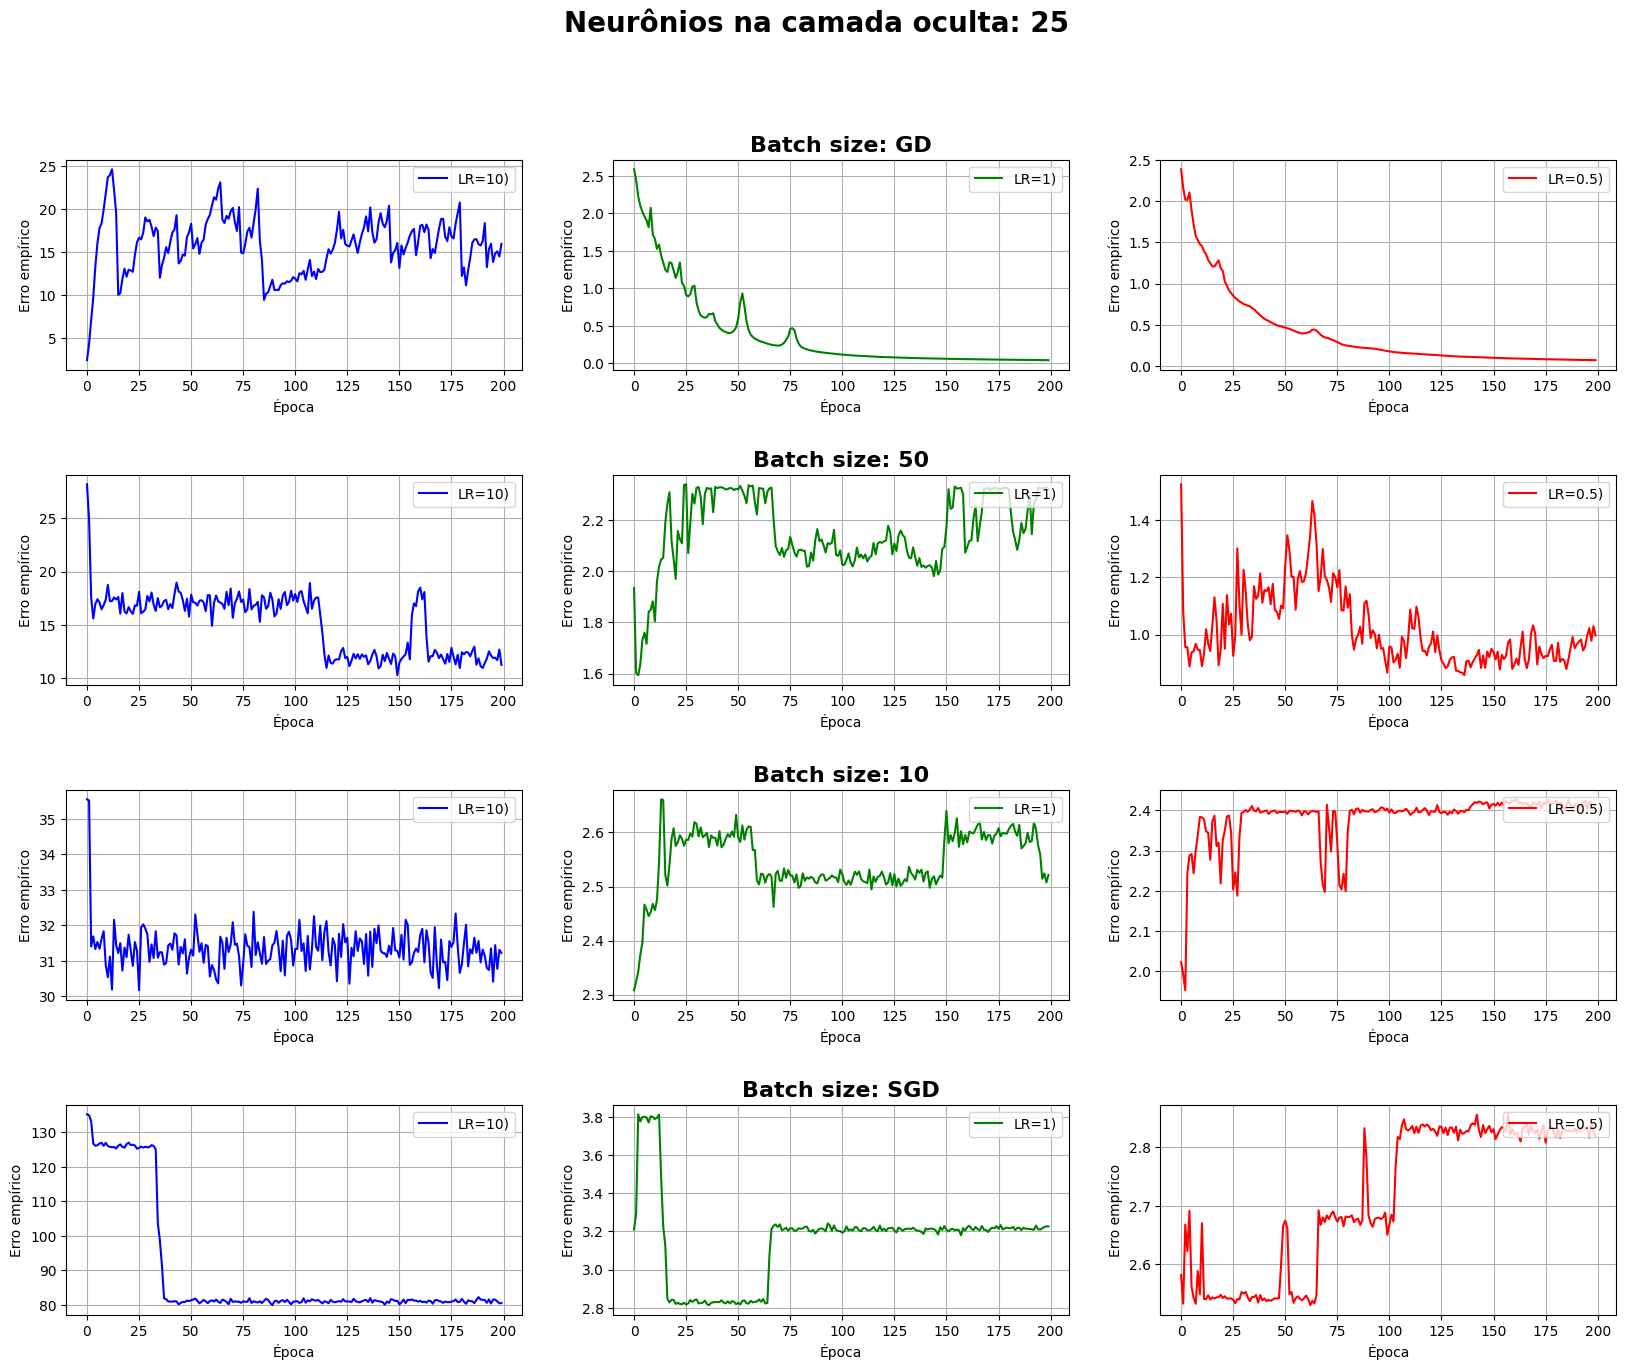

<Figure size 640x480 with 0 Axes>

In [41]:
displayMLP(25)

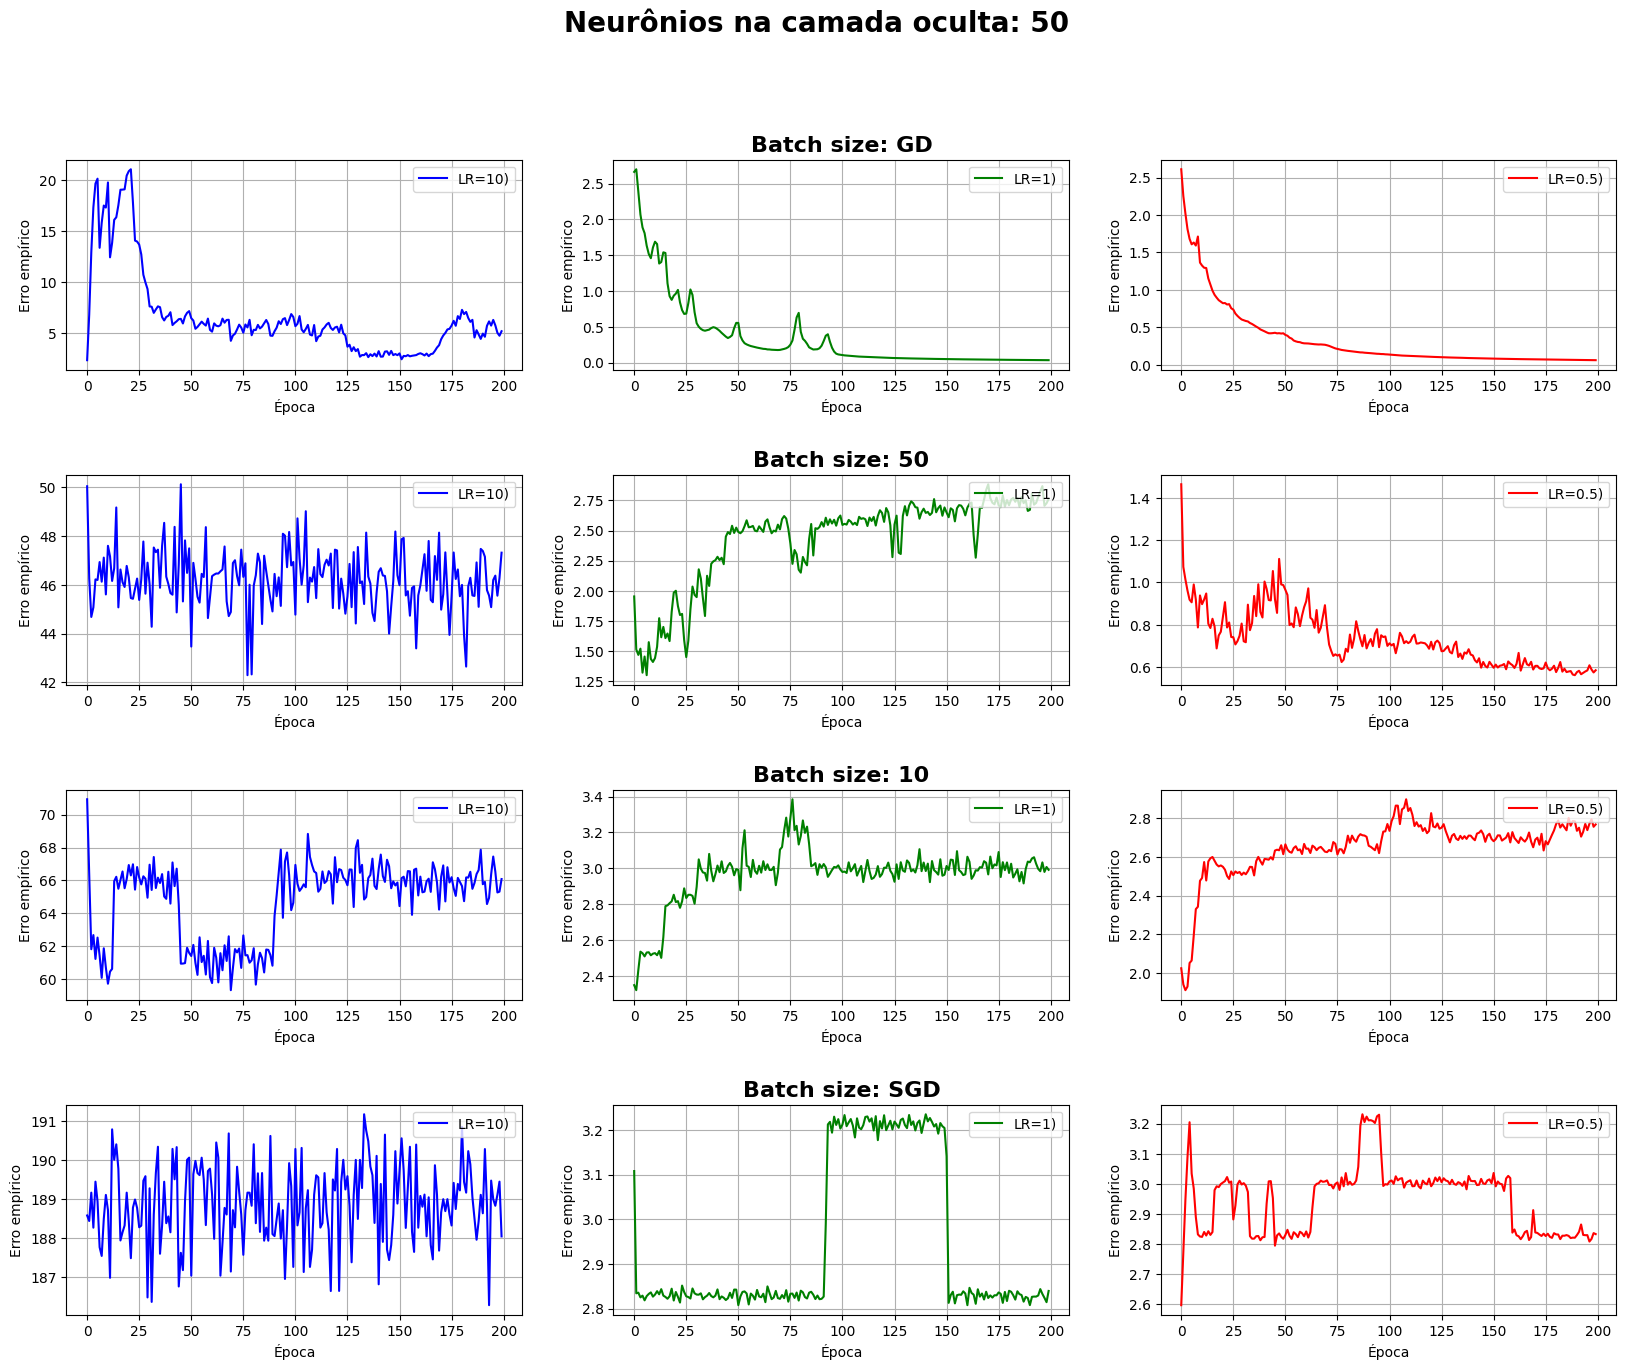

<Figure size 640x480 with 0 Axes>

In [42]:
displayMLP(50)

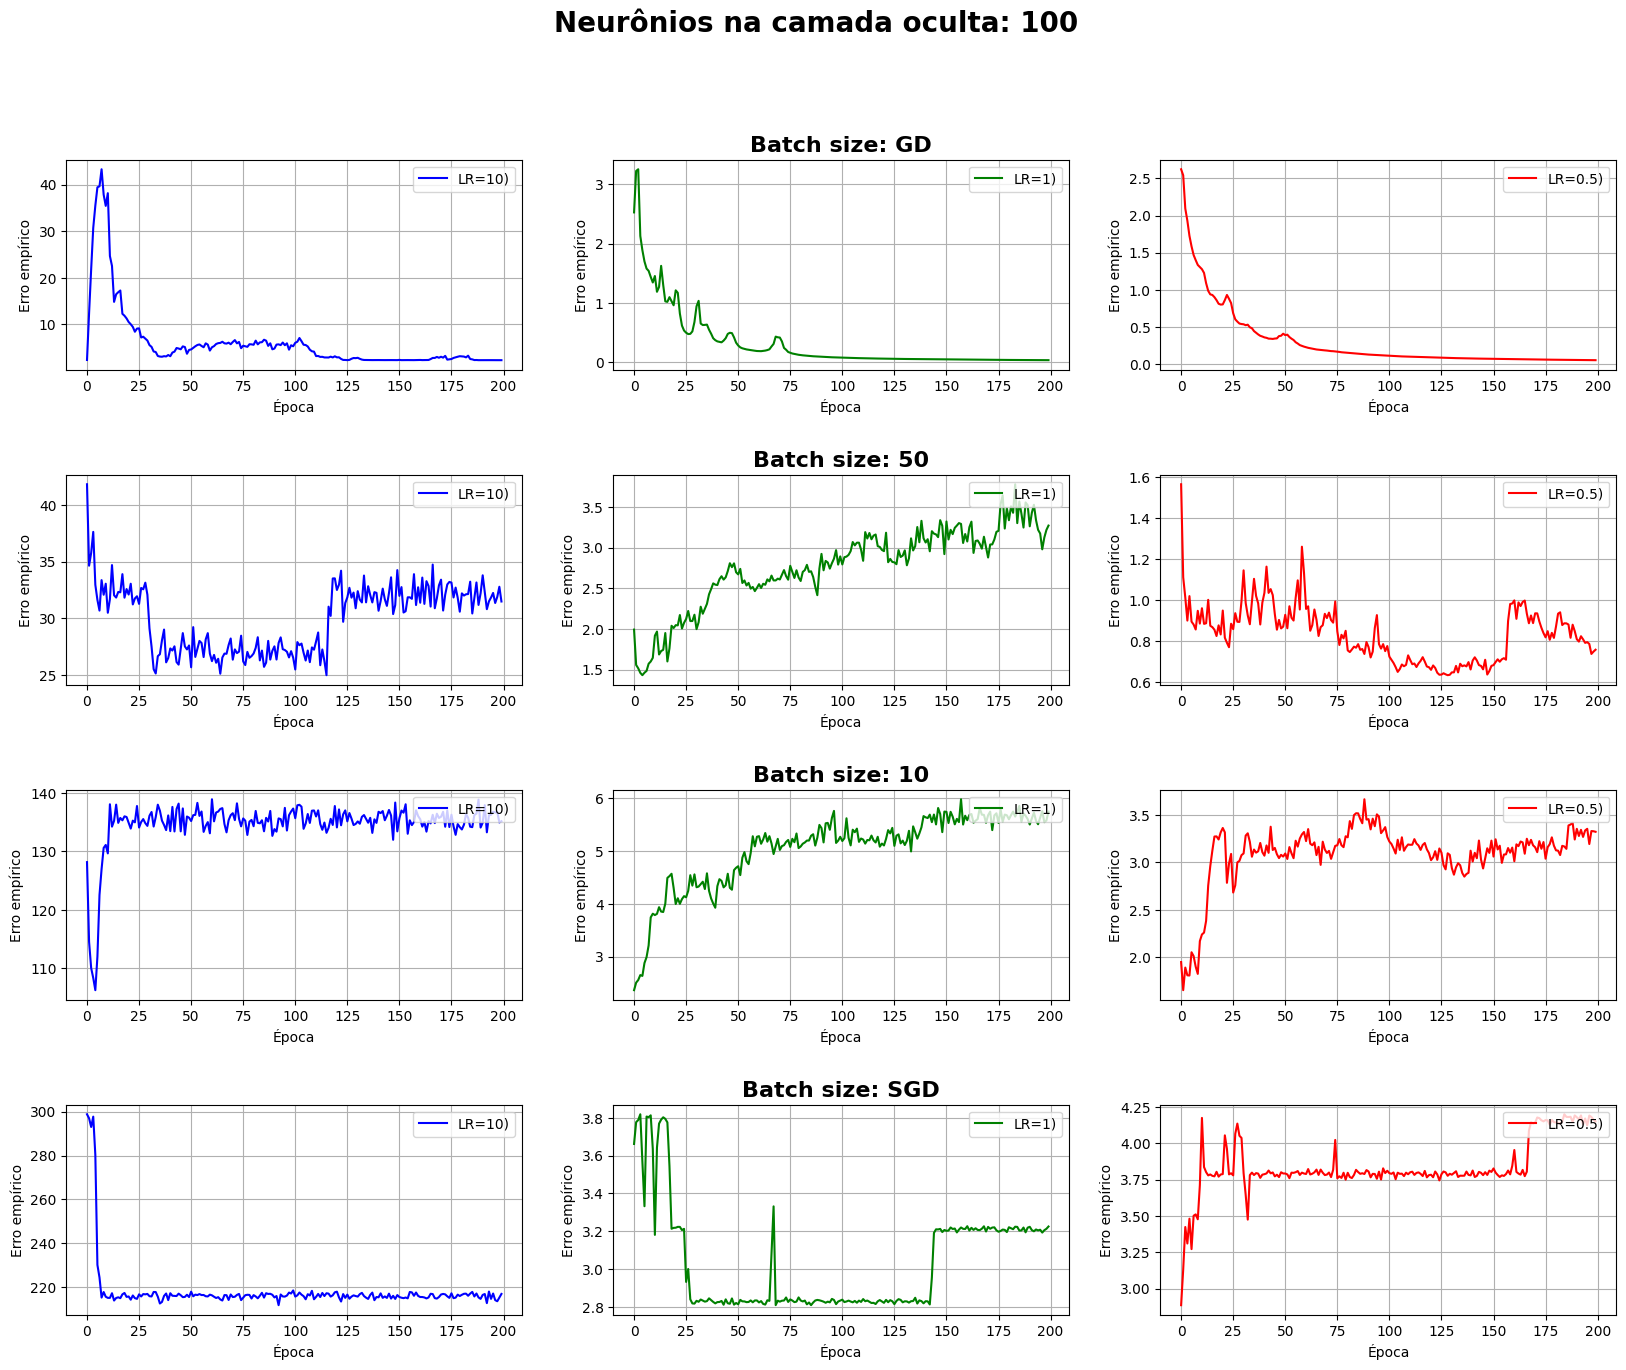

<Figure size 640x480 with 0 Axes>

In [45]:
displayMLP(100)

Função para plotar a variação do número de unidades na camada oculta para cada um dos três algoritmos de cálculo de gradiente.

In [46]:
def displayNeuronErrors():
    empirical_data = {}
    for hidden_layer_neuron_number, model_group in models.items():
        index = -1 

        for batch_size, model_group in model_group.items():
            index += 1
            last_epoch_loss = None
            last_epoch_eval_loss = None

            for learning_rate, model in model_group.items():
                if learning_rate == 0.5:
                    mlp, history = model
                    last_epoch_loss = history['loss'][-1]
                    last_epoch_eval_loss = history['val_loss'][-1]

            empirical_data[hidden_layer_neuron_number] = empirical_data.get(hidden_layer_neuron_number, [])
            empirical_data[hidden_layer_neuron_number].append(last_epoch_loss)

    x = params['hidden_layer_neuron_numbers']
    colors = ['blue', 'green', 'red', 'purple']
    for i in range(len(batch_sizes)):
        empirical_y = []

        for neuron_nb, batch_errors in empirical_data.items():
            empirical_y.append(batch_errors[i])

        batch_size = batch_sizes[i]
        if batch_size == 3750:
            batch_size = "GD"

        if batch_size == 1:
            batch_size = "SGD"

        plt.plot(x, empirical_y, label=f"Batch size: {batch_size}", color=colors[i])

    # invert the order of the labels
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], loc='upper right')

    plt.xlabel('Número de neurônios na camada oculta')
    plt.ylabel('Erro impírico na última época')
    # draw gridlines
    plt.grid(True)
    plt.xticks(x)
    plt.show()

Para simplificar a análise, escolhi os modelos com o menor learning rate (0.5), pois os resultados obtidos com outros learning rates são piores.

Podemos observar pelo gráfico abaixo que quanto maior o batch_size, menor o valor de convergência do erro empírico. Isso se deve à natureza caótica resultante de se ter batches menores.

Ao aumentar o número de neurônios na camada oculta, estamos aumentando a capacidade do modelo. É esperado que o erro empírico de modelos com maior capacidade seja menor, pois eles podem gerar funções mais complexas. Esse fato é evidenciado no modelo com batch_size=GD, mas não nos demais. A explicação para isso é que esses modelos acabaram caindo em mínimos locais devido aos menores batch_sizes. É fácil verificar essa hipótese ao retornar para os gráficos acima e observar como esses modelos caem em vários mínimos locais ao longo das épocas (até na última).

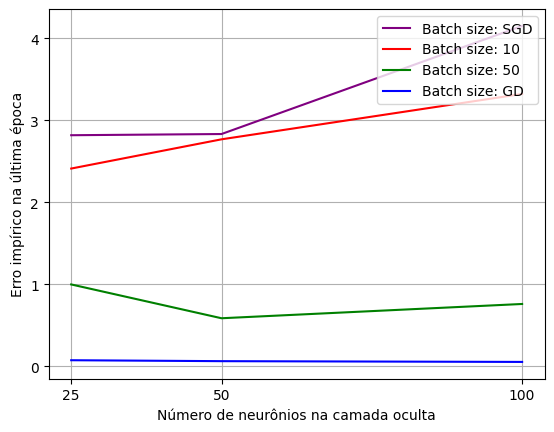

In [47]:
displayNeuronErrors()